# RxInfer.jl

Getting Started docs: https://biaslab.github.io/RxInfer.jl/stable/manuals/getting-started/

RxInfer.jl is a package for Bayesian Inference on Factor Graphs by Message Passing

In [19]:
# remove comment if RxInfer not installed
# using Pkg
# Pkg.add("RxInfer")
# import Pkg; Pkg.add("Distributions")
# import Pkg; Pkg.add("Random")
# import Pkg; Pkg.add("Plots")

## Inferring the bias of a coin

|Topic|Resources|
|---|---|
|Bernoulli Distribution | https://en.wikipedia.org/wiki/Bernoulli_distribution |
| Beta Distribution | https://en.wikipedia.org/wiki/Beta_distribution |
| `inference` function | https://biaslab.github.io/RxInfer.jl/stable/manuals/inference/inference/#user-guide-inference |

In [2]:
using RxInfer, Distributions, Random

In [3]:
rng = MersenneTwister(42) # random number generator with a reproducible seed
n = 10
p = 0.75
distribution = Bernoulli(p) # Bernoulli distribution

dataset = float.(rand(rng, Bernoulli(p), n)) # sample the Bernoulli distribution 10 times

10-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 1.0
 1.0
 0.0
 1.0

### Model specification
In a Bayesian setting, the next step is to specify our probabilistic model. This amounts to specifying the joint probability of the random variables of the system.

In [4]:
# GraphPPL.jl export `@model` macro for model specification
# It accepts a regular Julia function and builds an FFG under the hood
@model function coin_model(n)

    # `datavar` creates data 'inputs' in our model
    # We will pass data later on to these inputs
    # In this example we create a sequence of inputs that accepts Float64
    y = datavar(Float64, n)

    # We endow θ parameter of our model with some prior
    θ ~ Beta(2.0, 7.0)
    # or, in this particular case, the `Uniform(0.0, 1.0)` prior also works:
    # θ ~ Uniform(0.0, 1.0)

    # We assume that outcome of each coin flip is governed by the Bernoulli distribution
    for i in 1:n
        y[i] ~ Bernoulli(θ)
    end

    # We return references to our data inputs and θ parameter
    # We will use these references later on during inference step
    return y, θ
end

### Inference specification

In [10]:
result = inference(
    model = coin_model(length(dataset)),
    data  = (y = dataset, )
)

Inference results:
  Posteriors       | available for (θ)


In [11]:
θestimated = result.posteriors[:θ]

Beta{Float64}(α=9.0, β=10.0)

In [12]:
println("mean: ", mean(θestimated))
println("std:  ", std(θestimated))

mean: 0.47368421052631576
std:  0.11164843913471803


### Manual inference specification

In [13]:
function custom_inference(data)
    n = length(data)

    # `coin_model` function from `@model` macro returns a reference to the model generator object
    # we need to use the `create_model` function to get actual model object
    model, (y, θ) = create_model(coin_model(n))

    # Reference for future posterior marginal
    mθ = nothing

    # `getmarginal` function returns an observable of future posterior marginal updates
    # We use `Rocket.jl` API to subscribe on this observable
    # As soon as posterior marginal update is available we just save it in `mθ`
    subscription = subscribe!(getmarginal(θ), (m) -> mθ = m)

    # `update!` function passes data to our data inputs
    update!(y, data)

    # It is always a good practice to unsubscribe and to
    # free computer resources held by the subscription
    unsubscribe!(subscription)

    # Here we return our resulting posterior marginal
    return mθ
end

custom_inference (generic function with 1 method)

### Inference execution

In [14]:
θestimated = custom_inference(dataset)

Marginal(Beta{Float64}(α=9.0, β=10.0))

In [15]:
println("mean: ", mean(θestimated))
println("std:  ", std(θestimated))

mean: 0.47368421052631576
std:  0.11164843913471803


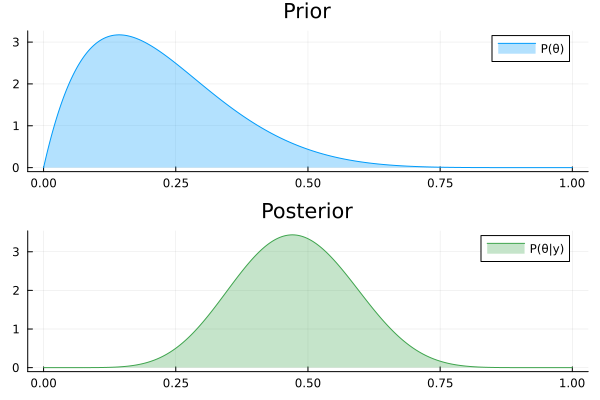

In [20]:
using Plots

rθ = range(0, 1, length = 1000)

p1 = plot(rθ, (x) -> pdf(Beta(2.0, 7.0), x), title="Prior", fillalpha=0.3, fillrange = 0, label="P(θ)", c=1,)
p2 = plot(rθ, (x) -> pdf(θestimated, x), title="Posterior", fillalpha=0.3, fillrange = 0, label="P(θ|y)", c=3)

plot(p1, p2, layout = @layout([ a; b ]))

RxInfer scales very well for large models and factor graphs

In [21]:
dataset_100   = float.(rand(rng, Bernoulli(p), 100))
dataset_1000  = float.(rand(rng, Bernoulli(p), 1000))
dataset_10000 = float.(rand(rng, Bernoulli(p), 10000))

10000-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 1.0
 1.0
 ⋮
 0.0
 1.0
 1.0
 0.0
 1.0
 0.0
 1.0
 1.0
 1.0

In [23]:
θestimated_100   = custom_inference(dataset_100)
θestimated_1000  = custom_inference(dataset_1000)
θestimated_10000 = custom_inference(dataset_10000)

Marginal(Beta{Float64}(α=7536.0, β=2473.0))

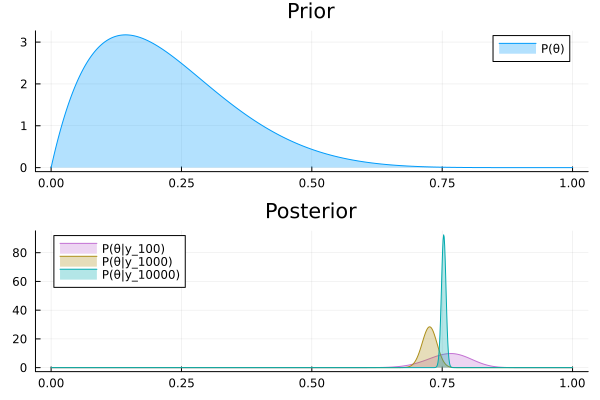

In [24]:
p3 = plot(title = "Posterior", legend = :topleft)

p3 = plot!(p3, rθ, (x) -> pdf(θestimated_100, x), fillalpha = 0.3, fillrange = 0, label = "P(θ|y_100)", c = 4)
p3 = plot!(p3, rθ, (x) -> pdf(θestimated_1000, x), fillalpha = 0.3, fillrange = 0, label = "P(θ|y_1000)", c = 5)
p3 = plot!(p3, rθ, (x) -> pdf(θestimated_10000, x), fillalpha = 0.3, fillrange = 0, label = "P(θ|y_10000)", c = 6)

plot(p1, p3, layout = @layout([ a; b ]))

In [25]:
println("mean: ", mean(θestimated_10000))
println("std:  ", std(θestimated_10000))

mean: 0.7529223698671196
std:  0.004310967761308469
